In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
customers = pd.read_csv('/content/Customers.csv')
products = pd.read_csv('/content/Products.csv')
transactions = pd.read_csv('/content/Transactions.csv')

**Data Preprocessing**

In [15]:
transactions = transactions.merge(customers, on='CustomerID', how='left')
transactions = transactions.merge(products, on='ProductID', how='left')

**Feature Engineering**

In [16]:
customer_transactions = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'Quantity': 'sum',    # Total quantity purchased
    'TransactionID': 'count'  # Number of transactions
}).rename(columns={
    'TotalValue': 'TotalSpending',
    'Quantity': 'TotalQuantity',
    'TransactionID': 'TransactionCount'
}).reset_index()

In [17]:
customer_transactions = customer_transactions.merge(customers[['CustomerID', 'Region', 'SignupDate']], on='CustomerID', how='left')

In [18]:
customer_transactions['SignupDate'] = pd.to_datetime(customer_transactions['SignupDate'])
customer_transactions['DaysSinceSignup'] = (pd.Timestamp('now') - customer_transactions['SignupDate']).dt.days
customer_transactions.drop(columns=['SignupDate'], inplace=True)

In [19]:
le = LabelEncoder()
customer_transactions['Region'] = le.fit_transform(customer_transactions['Region'])

In [20]:
scaler = StandardScaler()
features = ['TotalSpending', 'TotalQuantity', 'TransactionCount', 'DaysSinceSignup', 'Region']
customer_transactions_scaled = scaler.fit_transform(customer_transactions[features])

**Clustering**

In [21]:
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_transactions_scaled)
    inertia.append(kmeans.inertia_)

**Elbow Diagram**

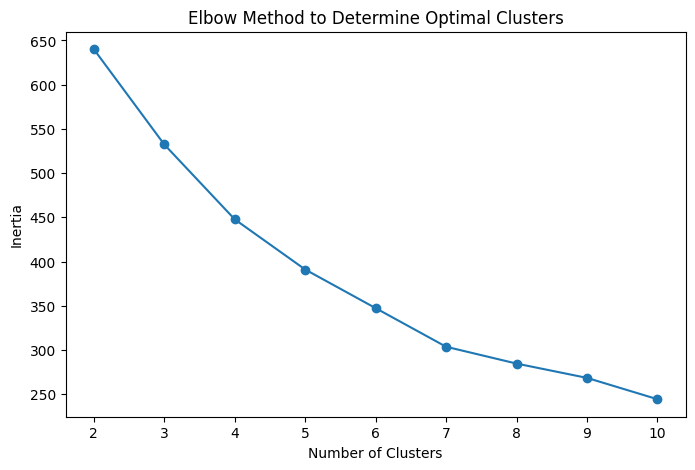

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.show()

In [23]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
customer_transactions['Cluster'] = kmeans.fit_predict(customer_transactions_scaled)

In [24]:
db_index = davies_bouldin_score(customer_transactions_scaled, customer_transactions['Cluster'])
silhouette_avg = silhouette_score(customer_transactions_scaled, customer_transactions['Cluster'])

print(f'Davies-Bouldin Index: {db_index}')
print(f'Silhouette Score: {silhouette_avg}')

Davies-Bouldin Index: 1.2426323697598636
Silhouette Score: 0.23483203415203088


**Visualize Clusters using PCA**

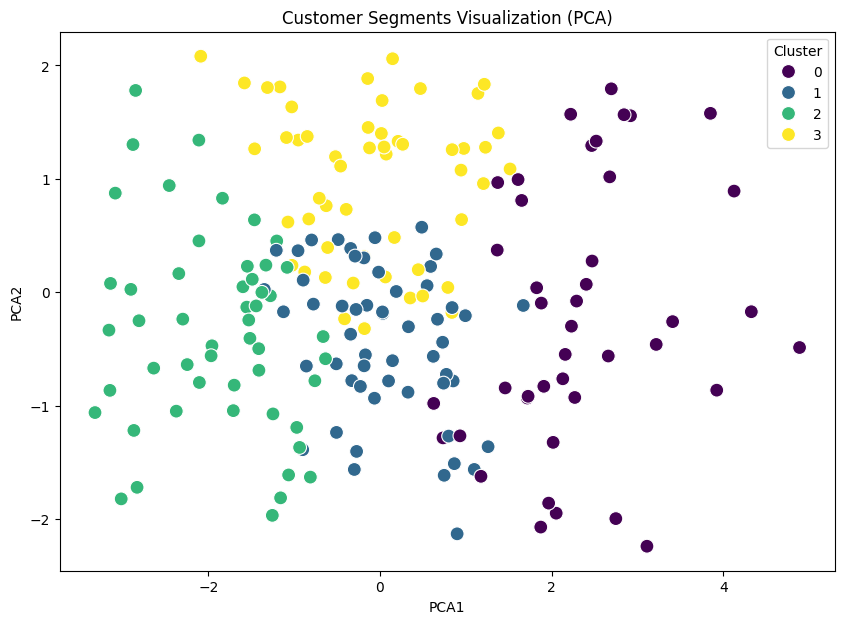

In [25]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(customer_transactions_scaled)
customer_transactions['PCA1'] = pca_result[:, 0]
customer_transactions['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customer_transactions,
    palette='viridis', s=100
)
plt.title('Customer Segments Visualization (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

In [26]:
customer_transactions.to_csv('Customer_Clusters.csv', index=False)